In [57]:
import yaml
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import copy
import os
import sys

sys.path.append(str(Path.cwd().parent))

from scripts import import_preprocessing1, data_filtering2, microbiome_filtering3, level_filtering4, plotting5

importlib.reload(import_preprocessing1)
importlib.reload(data_filtering2)
importlib.reload(microbiome_filtering3)

<module 'scripts.microbiome_filtering3' from '/ceph/projects/179_Oncdon/shawn.loo/workspace/scripts/microbiome_filtering3.py'>

In [2]:
# Loading configs

import_str = "/ceph/projects/179_Oncdon/shawn.loo/workspace/"

configs_path = Path(f"{import_str}configs/default_phylum.yaml")
with open(configs_path) as w:
    config = yaml.safe_load(w)

In [3]:
# Importing data
metadata_V107 = pd.read_excel(f"{import_str}data/rawdata/CC_longitudinal_data_standardized_v220250603.xlsx", sheet_name = "CC_longitudinal_metadata")
metadata_V142 = pd.read_excel(f"{import_str}data/rawdata/V350218142_batchC_CC_longitudinal_metadata_dev1_v220250603.xlsx")
metadata_E975 = pd.read_excel(f"{import_str}data/rawdata/E100051975_BR_longitudinal_metadata_dev1_v220250603.xlsx", sheet_name = "BR_longitudinal_metadata")

metadata_set = [metadata_V107, metadata_V142, metadata_E975]

In [4]:
# Loading in data, separating duplicates
# Returns lists of dataset:
# [V107_dup_A_df, V107_dup_B_df, V142_dup_A_df, V142_dup_B_df, E975_df]
dataset = import_preprocessing1.load_and_process_data()

# Removing duplicates, huge differences in duplicates are included in the data
filtered_dataset = data_filtering2.filter_data(dataset)

# Microbiome filtering
microbiome_filtered_df = microbiome_filtering3.run_microbiome_filtering(filtered_dataset, config)

In [5]:
def level_filtering(df, filtering):

    # Level Map
    level_map = {
        "kingdom": "k__",
        "phylum": "p__",
        "class": "c__",
        "order": "o__",
        "family": "f__",
        "genus": "g__",
        "species": "s__"
    }

    level = level_map.get(filtering.lower())

    # Perform filtering based on passed in parameter mapped to Level Map and name the column
    new_column = df["taxon_name"].str.extract(fr'{level}([^|]+)')
    
    # Inserting new column
    df.insert(0, filtering, new_column)
    
    # Dropping NaN columns
    filtered_df = df.dropna(subset=["taxon_name"])

    return filtered_df

In [6]:
temp_df = {}

for flowcell, df in microbiome_filtered_df.items():
    
    # Applying filter
    temp_df[flowcell] = level_filtering(df, "phylum")
    
    # Creating genus column
    temp_df[flowcell]["genus"] = temp_df[flowcell]["taxon_name"].str.extract(r"g__([^|]+)")[0]
    
    # Dropping NA
    temp_df[flowcell] = temp_df[flowcell].dropna(subset=["genus"])
    
    # Grouping by genus
    grouped_genus = temp_df[flowcell].groupby("genus").sum()
    
    # Retrieving phylum col value for each genus
    phylum_under_genus = temp_df[flowcell].groupby("genus")["phylum"].first()
    
    # Add phylum back as a column
    grouped_genus["phylum"] = phylum_under_genus
    
    # Reset index to get taxon_name back as a column
    temp_df[flowcell] = grouped_genus.reset_index()
    
    # Dropping unused column
    temp_df[flowcell].drop("taxon_name", axis=1, inplace=True)

Grouping data based on phylum

In [7]:
# Grouping 

flowcell_id = ["V107", "V142", "E975"]
genus_df = {}

for ids in flowcell_id:
    
    flowcell = {}
    
    phylum = temp_df[ids]["phylum"].unique()

    for phylum_name in phylum:

        flowcell[phylum_name] = temp_df[ids][temp_df[ids]["phylum"] == phylum_name].copy()
        
        # Dropping unused column
        flowcell[phylum_name].drop("phylum", axis=1, inplace=True)
        
    genus_df[ids] = flowcell

In [9]:
genus_df["V107"]["Firmicutes"]

,genus,179supA00011a,179supA00012a,179supA00013a,179supA00014a,179supA00015a,179supA00016a,179supA00021a,179supA00022a,179supA00023a,...,179supD00619a,179supD00620a,179supD00621a,179supD00622a,FF02556036,FF02556045,FF02556056,FF02556063,FF02556074,FF02556082
0,Acidaminococcus,0.00000,20.85189,0.00000,0.0000,0.00000,0.00000,0.00000,7.99548,0.00000,...,133.57227,0.0,53.98509,0.00000,0.00000,58.15239,0.00000,0.00000,0.00000,0.00000
3,Agathobaculum,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.73343,0.00000,1.41906,0.06012,0.34344,1.28406
6,Allisonella,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,Anaerobutyricum,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00048,0.33156,0.13639,1.57084
8,Anaerococcus,0.04986,42.18057,13.60047,0.0000,16.74597,0.59064,1.25811,10.22544,9.76326,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.71871,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Solobacterium,0.00000,0.00000,0.00000,0.0000,0.75072,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
151,Streptococcus,20.46858,9.97389,9.81775,0.0131,11.80368,95.53077,1.34218,7.55850,0.00000,...,0.00000,0.0,3.06963,1.43823,0.00000,1.05558,0.15322,0.12392,0.60804,5.06742
153,Veillonella,42.04525,37.33833,70.63212,0.0000,45.01786,47.36727,27.60045,6.58245,71.93222,...,0.00000,0.0,0.00000,13.19844,0.00000,0.00000,16.94813,0.00000,0.00000,0.00000
154,Vescimonas,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.0,0.00000,0.00000,0.29889,0.10344,0.00000,4.98048,6.28983,0.00000


In [12]:
flowcell_ids = ["V107", "V142", "E975"]

samples_by_week = {}

for idx in range(len(metadata_set)):

    # Getting rows in metadata based on the sample_names in our current data
    filtered_df = metadata_set[idx][metadata_set[idx]["sample_id"].isin(microbiome_filtered_df[flowcell_ids[idx]].columns)]

    # Extracting needed columns
    filtered_df = filtered_df[["sample_id", "sample_description"]]

    # Grouping them based on weeks
    filtered_df = filtered_df.groupby("sample_description")["sample_id"].apply(list).to_dict()

    # Storing
    samples_by_week[flowcell_ids[idx]] = filtered_df


# Handling duplicates to be included into the same week
samples_by_week["V107"]["cul_wk6_a"].extend(samples_by_week["V107"]["cul_wk6_b"])

del samples_by_week["V107"]["cul_wk6_b"]

# Repeat for other duplicate
samples_by_week["V142"]["cul_wk1_a"].extend(samples_by_week["V142"]["cul_wk1_b"])
del samples_by_week["V142"]["cul_wk1_b"]


In [14]:
samples_by_week["V107"][.keys()]

['179supA00011a',
 '179supA00012a',
 '179supA00013a',
 '179supA00014a',
 '179supA00015a',
 '179supA00016a',
 '179supB00017a',
 '179supB00018a',
 '179supB00019a',
 '179supB00110a',
 '179supB00111a',
 '179supB00112a',
 '179supD00119a',
 '179supD00120a',
 '179supD00121a',
 '179supD00122a']

In [16]:
main_dataset = {}

for flowcell, weeks in samples_by_week.items():

    main_dataset[flowcell] = {}

    for week, sample_id in weeks.items():

        main_dataset[flowcell][week] = microbiome_filtered_df[flowcell][sample_id]

# Resorting duplicates dataset
main_dataset["V107"]["cul_wk6_a"] = main_dataset["V107"]["cul_wk6_a"].reindex(sorted(main_dataset["V107"]["cul_wk6_a"].columns), axis=1)
main_dataset["V142"]["cul_wk1_a"] = main_dataset["V142"]["cul_wk1_a"].reindex(sorted(main_dataset["V142"]["cul_wk1_a"].columns), axis=1)


# Reordering them

# For V107
colnames = list(main_dataset["V107"].items())
reordered = [colnames[-1]] + colnames[:-1]
main_dataset["V107"] = dict(reordered)

# For E975
E975_order = ['fecal_slurry', 'cul_Day4', 'cul_Day8', 'cul_Day12']
main_dataset["E975"] = {key: main_dataset["E975"][key] for key in E975_order}


In [19]:
main_dataset["V107"]["cul_wk1_a"]

,179supA00011a,179supA00012a,179supA00013a,179supA00014a,179supA00015a,179supA00016a,179supB00017a,179supB00018a,179supB00019a,179supB00110a,179supB00111a,179supB00112a,179supD00119a,179supD00120a,179supD00121a,179supD00122a
1,63.85953,64.35851,70.35730,47.47956,78.29471,83.87218,63.59829,64.17773,63.97974,72.18577,47.21922,54.23205,69.18749,84.12472,40.01588,77.34347
2,19.90547,2.53669,8.20009,9.52566,8.56002,5.91602,16.35901,4.27742,11.22031,3.93038,13.26803,9.03502,11.39798,9.88558,8.23882,6.13336
3,5.92528,11.79229,10.17911,17.06389,5.33324,6.30580,13.62673,30.36086,14.75214,13.15615,19.28245,17.66541,0.05631,0.20325,4.25746,5.91165
4,10.17133,21.28046,11.13801,25.93088,7.79571,3.86615,4.85127,1.05425,10.04781,10.46943,20.11942,18.12190,19.30228,5.72476,47.08646,10.53542
5,3.41034,1.85230,4.16105,4.64768,8.11914,4.15655,8.09590,2.55005,9.53085,3.01872,6.29580,4.64312,1.51500,4.92328,5.04972,5.93147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01949,0.00000,0.11487,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2752,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01949,0.00000,0.11487,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2764,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.01949,0.00000,0.11487,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2779,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00380,0.00000,0.00000,0.00000,0.00000,0.00000


Grouping genus dataset into respective weeks

In [23]:
genus_main_dataset = {}

for flowcell, weeks in main_dataset.items():
    
    genus_main_dataset[flowcell] = {}
    genera = genus_df.get(flowcell, {})
    
    for week, df in weeks.items():
        
        genus_main_dataset[flowcell][week] = {}
            
        for genus, g_df in genera.items():
                
            # Choosing what to keep
            cols_to_keep = ["genus"] + [col for col in g_df.columns if col in df.columns]

            completed_df = g_df[cols_to_keep]

            genus_main_dataset[flowcell][week][genus] = completed_df                

In [28]:
genus_main_dataset["V107"]["cul_wk1_a"]["Firmicutes"]

,genus,179supA00011a,179supA00012a,179supA00013a,179supA00014a,179supA00015a,179supA00016a,179supB00017a,179supB00018a,179supB00019a,179supB00110a,179supB00111a,179supB00112a,179supD00119a,179supD00120a,179supD00121a,179supD00122a
0,Acidaminococcus,0.00000,20.85189,0.00000,0.0000,0.00000,0.00000,16.97358,0.00000,0.00000,0.00000,0.00000,0.00000,42.52866,0.00000,21.92091,0.00000
3,Agathobaculum,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.33294,0.17898,0.00000,0.24828,0.00000,0.57750,0.00000,0.05217,0.00000,0.00000
6,Allisonella,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,4.05819,0.00000,0.66069,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,Anaerobutyricum,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,4.36089,0.00000,2.24928,0.10266,0.00000,0.31968,0.00000,0.03795,0.00000,0.00000
8,Anaerococcus,0.04986,42.18057,13.60047,0.0000,16.74597,0.59064,0.00000,0.00000,0.00000,0.00000,0.02127,0.00000,0.00000,0.00000,0.00000,3.46994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,Solobacterium,0.00000,0.00000,0.00000,0.0000,0.75072,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
151,Streptococcus,20.46858,9.97389,9.81775,0.0131,11.80368,95.53077,4.96939,32.92053,6.36803,57.07251,14.07879,1.71461,1.39503,58.77433,12.07663,38.97684
153,Veillonella,42.04525,37.33833,70.63212,0.0000,45.01786,47.36727,0.00000,0.22791,0.00000,10.66986,0.37494,0.00000,0.00000,33.71790,17.50329,1.32500
154,Vescimonas,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,2.14818,0.00000,0.10353,0.25038,0.00000,0.00000,0.00000,0.19866,0.08250,0.00000


In [33]:
# Check for DataFrames that only have the "genus" column
genus_only_count = 0
total_dataframes = 0

for flowcell, weeks in genus_main_dataset.items():
    for week, genera in weeks.items():
        for genus, df in genera.items():
            total_dataframes += 1
            
            # Check if this DataFrame only has the "genus" column
            if list(df.columns) == ["genus"]:
                genus_only_count += 1
                print(f"Found genus-only DataFrame: flowcell={flowcell}, week={week}, genus={genus}")
                print(f"  Shape: {df.shape}")
                print(f"  Columns: {list(df.columns)}")
                print()

print(f"Summary:")
print(f"Total DataFrames: {total_dataframes}")
print(f"DataFrames with only 'genus' column: {genus_only_count}")
print(f"Percentage: {(genus_only_count/total_dataframes)*100:.1f}%" if total_dataframes > 0 else "N/A")

Summary:
Total DataFrames: 167
DataFrames with only 'genus' column: 0
Percentage: 0.0%


In [64]:
df = genus_main_dataset["V107"]["cul_wk1_a"]["Proteobacteria"].set_index("genus").copy()

In [73]:
def bubble_plot(df):
    
    # Format for bubble plot
    melted = df.reset_index().melt(id_vars='genus', var_name='samples', value_name='abundance')
    
    # Setting zeros to 'no bubble'
    abundance_size = melted["abundance"].replace(0, np.nan)
    
    plt.figure(figsize = (8, 6))
    sns.scatterplot(
    data = melted,
    x = 'samples',
    y = df.index.name,
    size = abundance_size,
    hue = 'abundance',
    sizes = (20, 500),
    palette ='viridis',
    alpha =0.7)
    
    plt.grid(linewidth = 0.3, alpha = 0.7)
    plt.title("", fontsize=14)
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

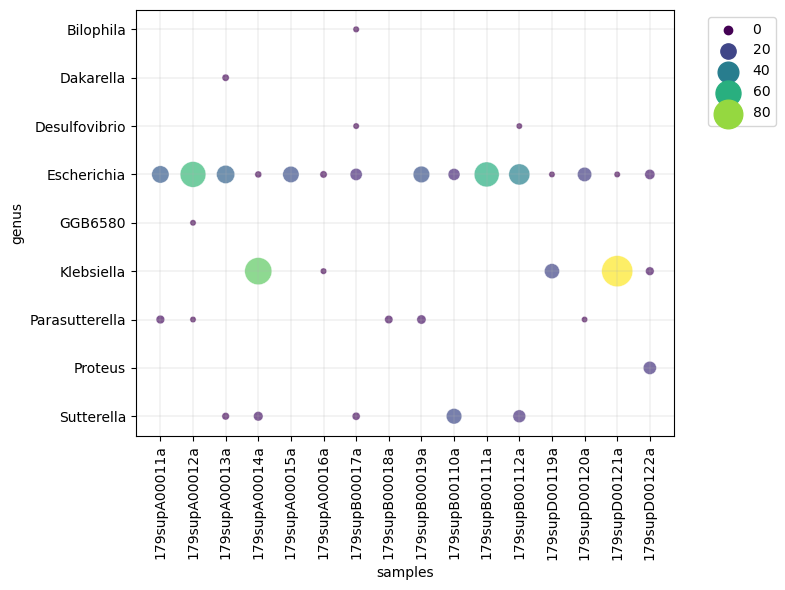

In [74]:
bubble_plot(df)

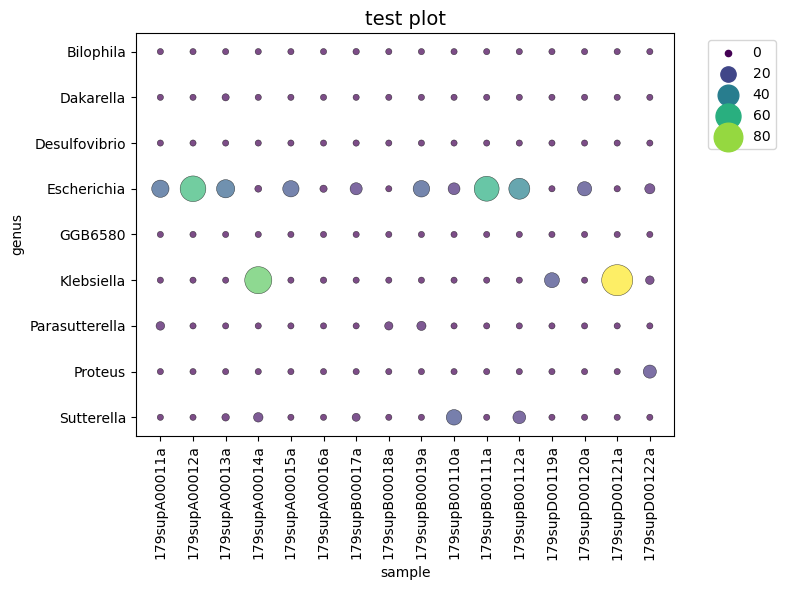

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_long,
    x='sample',
    y=df.index.name or 'index',
    size='abundance',
    hue='abundance',
    sizes=(20, 500),
    palette='viridis',
    edgecolor='black',
    alpha=0.7
)
plt.title("test plot", fontsize=14)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()